#### Database

In [1]:
PROJECT_PATH = '/home/md/Work/ligalytics/leagues_stable/'
import os, sys
sys.path.insert(0, PROJECT_PATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "leagues.settings")

from leagues import settings
settings.DATABASES['default']['NAME'] = PROJECT_PATH+'/db.sqlite3'

import django
django.setup()

from scheduler.models import *
from common.functions import distanceInKmByGPS
season = Season.objects.filter(nicename="Imported: Benchmark Season").first()
import pandas as pd
import numpy as np
from django.db.models import F
games = Game.objects.filter(season=season)
df = pd.DataFrame.from_records(games.values())
games = Game.objects.filter(season=season).exclude(historic_season=None).annotate(
    home=F('homeTeam__shortname'),
    away=F('awayTeam__shortname'),
    home_lat=F('homeTeam__latitude'),
    home_lon=F('homeTeam__longitude'),
    home_attr=F('homeTeam__attractivity'),
    away_lat=F('awayTeam__latitude'),
    away_lon=F('awayTeam__longitude'),
    away_attr=F('awayTeam__attractivity'),
    home_country=F('homeTeam__country'),
    away_country=F('awayTeam__country'),
).values()



#### Dataframe

In [2]:
from sklearn.preprocessing import OneHotEncoder

# create dataset
df = pd.DataFrame.from_records(games.values())

# data cleaning
df['time'] = df['time'].replace('','0')
df = df[df['attendance'] != 0]

# remove outliers
out_fields = ['attendance']
for field in out_fields:
    q_low = df[field].quantile(0.01)
    q_hi  = df[field].quantile(0.99)
    df = df[(df[field] < q_hi) & (df[field] > q_low)]


# pivots
pivot_homeTeam_mean = df.pivot_table('attendance','homeTeam_id',aggfunc='mean')
pivot_homeTeam_max = df.pivot_table('attendance','homeTeam_id',aggfunc='max')

# add more features
df['weekday'] = df.apply(lambda r: r['date'].weekday(), axis=1)
df['day'] = df.apply(lambda r: r['date'].day, axis=1)
df['month'] = df.apply(lambda r: r['date'].month, axis=1)
df['year'] = df.apply(lambda r: r['date'].year, axis=1)
df['distance'] = df.apply(lambda r: distanceInKmByGPS(r['home_lon'],r['home_lat'],r['away_lon'],r['away_lat']), axis=1)
df['weekend'] = df.apply(lambda r: int(r['weekday'] in [6,7]), axis=1)
df['winter_season'] = df.apply(lambda r: int(r['month'] in [1,2,3,10,11,12]), axis=1)
df['home_base'] = df.apply(lambda r: pivot_homeTeam_mean.loc[r['homeTeam_id'],'attendance'], axis=1)
df['stadium_size'] = df.apply(lambda r: pivot_homeTeam_max.loc[r['homeTeam_id'],'attendance'], axis=1)
df['early'] = df.apply(lambda r: r['time'].replace(':','') < "1800", axis=1)
df['before2010'] = df.apply(lambda r: r['historic_season'].split('-')[0] < "2010", axis=1)



# one hot encoding
ohe_fields = ['home_country']

for field in ohe_fields:
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(df[[field]])
    df[ohe.categories_[0]] = transformed.toarray()

# sort label to last index
cols = list(df.columns)
cols.append(cols.pop(cols.index('attendance')))
df = df[cols]

#### Train/Test Data - Normalization

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor


remove_columns = ['season_id', 'resultEntered', 'reversible', 'reschedule', 'homeGoals', 'awayGoals',
                  'homeGoals2', 'awayGoals2', 'homeGoals3', 'awayGoals3', 'home', 'away', 'date', 'time',
                  'id',  'historic_season',
                  'home_country','home_lat','home_lon','away_lat','away_lon','away_country','year']
feature_cols = list(set(df.columns[:-1]) - set(remove_columns))
# feature_cols = ['weekday','weekend','home_base','distance','winter_season']
label = 'attendance'


data = df[feature_cols+[label]]




X = df[feature_cols]  # Features
y = df[label]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

In [4]:
rf_regressor = GradientBoostingRegressor(n_estimators = 200 ,  random_state = 42)
rf_regressor.fit(X_train,y_train)

# #Predicting the SalePrices using test set 
y_pred_rf = rf_regressor.predict(X_test)

# #Random Forest Regression Accuracy with test set
print('Random Forest Regression Accuracy: ', rf_regressor.score(X_test,y_test))

# #Predicting the SalePrice using cross validation (KFold method)
# y_pred_rf = cross_val_predict(rf_regressor, X, y, cv=10 )

# #Random Forest Regression Accuracy with cross validation
# accuracy_rf = metrics.r2_score(y, y_pred_rf)
# print('Cross-Predicted(KFold) Random Forest Regression Accuracy: ', accuracy_rf)

Random Forest Regression Accuracy:  0.6976274695189291


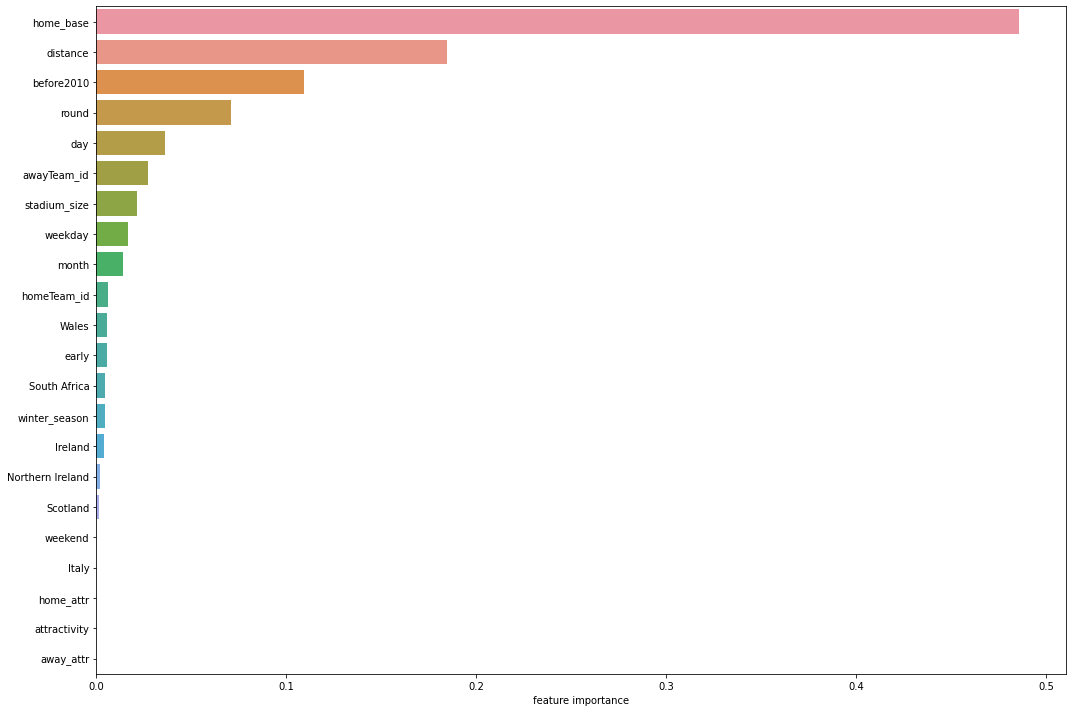

In [5]:
ranking = np.argsort(-rf_regressor.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=rf_regressor.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [6]:
for i,v in enumerate(y):
    print(i,v,y_pred_rf[i])

0 4000 6269.331273160804
1 3264 2212.472559220525
2 6000 4474.321544046366
3 4250 5853.876279843164
4 1200 2724.8479999971523
5 4300 12248.194405029995
6 3874 12179.504105471333
7 2800 7179.957816540268
8 5500 4343.454242132351
9 6000 15615.670772432313
10 3500 2142.013025198476
11 4500 6581.086576491373
12 2140 2787.000793225451
13 3146 7948.163004948026
14 2600 5277.360995538767
15 4875 4182.090794311384
16 5807 1298.0546590068432
17 5200 7641.152367897079
18 3500 12709.91385314257
19 2643 13796.44798966877
20 4000 2910.0979973906897
21 2500 11367.203439146624
22 2000 4578.676165761646
23 3198 11801.197736843704
24 3571 3256.2683962230926
25 2712 13963.658569196019
26 2100 3428.2076365623343
27 4525 3179.082309242862
28 6625 5319.700728374097
29 4966 4814.201898718184
30 2000 11668.774282716573
31 2100 16459.759735440115
32 2310 10424.049272604385
33 2600 3249.7584854521983
34 2000 4933.417332760704
35 4300 11330.47572253357
36 2734 4916.62667788047
37 3500 7616.108008546191
38 3050 

IndexError: index 652 is out of bounds for axis 0 with size 652

In [7]:
len(y)

2171